# 1.데이터 준비
- 데이터 호출 : 1. 파이썬 라이브러리(Pandas)이용, 2. 파이토치에서 제공하는 데이터 이용
  - 데이터가 이미지일 경우 : 분산된 파일에서 데이터를 읽기 - 전처리 - 배치 단위로 분할 처리
  - 데이터가 텍스트일 경우 : 임베딩 과정 - 서로 다른 길이의 시퀀스를 배치 단위로 분할 처리

## 1. 파이썬 라이브러리(Pandas)이용

### 단순하게 파일을 불러와서 사용

1.   필요한 라이브러리 설치 : pip install pandas
2.   예제 진행을 위한 라이브러리 호출

In [ ]:
import pandas as pd
import torch
data = pd.read_csv('../class2.csv')

x = torch.from_numpy(data['x'].values).unsqueeze(dim=1).float() # csv 파일의 x 칼럼의 값을 넘파일 배열로 받아 Tensor(dtype)으로 바꾸어 줍니다.
y = torch.from_numpy(data['y'].values).unsqueeze(dim=1).float() # csv 파일의 x 칼럼의 값을 넘파일 배열로 받아 Tensor(dtype)으로 바꾸어 줍니다.


### 커스텀 데이터셋을 만들어서 사용
- 딥러닝은 대량의 데이터를 이용하여 모델을 학습시킴
- 데이터를 한 번에 다 부르지 않고 조금씩 나누어 불러서 사용하는 **커스텀 데이터셋(custom dataset)**방식이 시간과 비용 측면에서 효율적임

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
  def __init__(self,csv_file): # csv_file 파라미터를 통해 데이터셋을 불러옴
    self.label = pd.read_csv(csv_file)

  def __len__(self): # 전체 데이터 셋의 크기(size)를 반환
    return len(self.label)

  def __getitem__(self, idx): # 전체 x와 y 데이터 중에 해당 idx번째의 데이터를 가져옴
    sample = torch.tensor(self.label.ilox[idx,0:3]).int()
    label = torch.tensor(self.label.iloc[idx,3]).int()
    return sample, label


  tensor_dataset = CustomDataset('../covtype.csv')
  dataset = DataLoader(tensor_dataset,batch_size=4,shuffle=True)

- **torch.utils.data.DataLoader**
  - 데이터로더 객체는 학습에 사용될 데이터 전체를 보관했다가 모델 학습을 할 때 배치 크기만큼 데이터를 꺼내서 사용함
  - 데이터를 미리 잘라 놓는 것이 아니라, 내부적으로 반복자(iterator)에 포함된 인덱스(index)를 이용하여 배치 크기만큼 데이터를 반환하는 것

##2. 파이토치에서 제공하는 데이터 이용
- torchvision은 파이토치에서 제공하는 데이터셋이 모여있는 패키지
  해당 데이터셋을 내려받으려면 먼저 requests 라이브러리 설치 필요
  - requests : Http 요청에 대한 처리를 위해 사용됨, 기본 내장 모듈이 아니기 때문에 별도 설치 필요

In [18]:
pip install requests

###MNIST 데이터셋을 내려받는 예제

In [19]:
import torchvision.transforms as transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(1.0,)) # 평균0.5, 표준편차가 1.0이 되도록 데이터의 분포(normalize)를 조정
])

In [20]:
from torchvision.datasets import MNIST
import requests

download_root = '../chap02/data/MNIST_DATASET'

train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True) # 훈련 데이터셋
valid_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True) # 검증 데이터셋
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True) # 테스트 데이터셋

# 2.모델 정의

- 파이토치에서 모델을 정의하기 위해서는 모듈(module)을 상속한 클래스 사용
  - 계층(layer) : 모듈 또는 모듈을 구성하는 한 개의 계층으로 합성곱층(convolutional layer), 선형계층(linear layer)등
  - 모듈(module) : 한 개 이상의 계층이 모여서 구성된 것으로, 모듈이 모여 새로운 모듈을 만들 수도 있음
  - 모델(model) : 최종적으로 원하는 네트워크로, 한 개의 모듈이 모델이 될 수도 있음

### 2.1 단순 신경망을 정의하는 방법
  - nn.Module을 상속받지 않는 매우 단순한 모델을 만들 때 사용 - 구현이 쉽고 단순

In [21]:
model = nn.Linear(in_features=1, out_features=1, bias=True)

### 2.2 nn.Module()을 상속하여 정의하는 방법
- **__ init__(), forward()** : 파이토치에서 nn.Module을 상속받는 모댈
  - **__ init__()** : 모델에서 사용될 모듈(nn.Linear ,nn.Conv2d), 활성화 함수 등 정의
  - **forward()** : 모델에서 실행되어야 하는 연산 정의


In [ ]:
class MLP(Module):
  def __init__(self, inputs):
    super(MLP,self).__init__()
    self.layer = Linear(inputs,1) # 계층 정의
    self.activation = Sigmoid() # 활성화 함수 정의

  def forward(self, X):
    X = self.layer(X)
    X = self.activation(X)
    return X

### 2.3 Sequential 신경망을 정의하는 방법
- nn.Sequential을 사용하면 __ init__()에서 사용할 네트워크 모델들을 정의해 줄 뿐만 아니라, forward() 함수에서는 모델에서 실행되어야 할 계산을 좀 더 가독성이 뛰어나게 코드로 작성할 수 있음
- 또한, Sequential 객체는 그 안에 포함된 각 모듈을 순차적으로 실행해줌
- nn.Sequential은 모델의 계층이 복잡할 수록 효과가 뛰어남

In [23]:
import torch.nn as nn
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2))

    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=30, kernel_size=5),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2))

    self.layer3 = nn.Sequential(
        nn.Linear(in_features=30*5*5, out_features=10, bias=True),
        nn.ReLU(inplace=True))

    def forward(self,x):
      x = self.layer1(x)
      x = self.layer2(x)
      x = x.view(x.shape[0],-1)
      x = self.layer3(x)
      return x

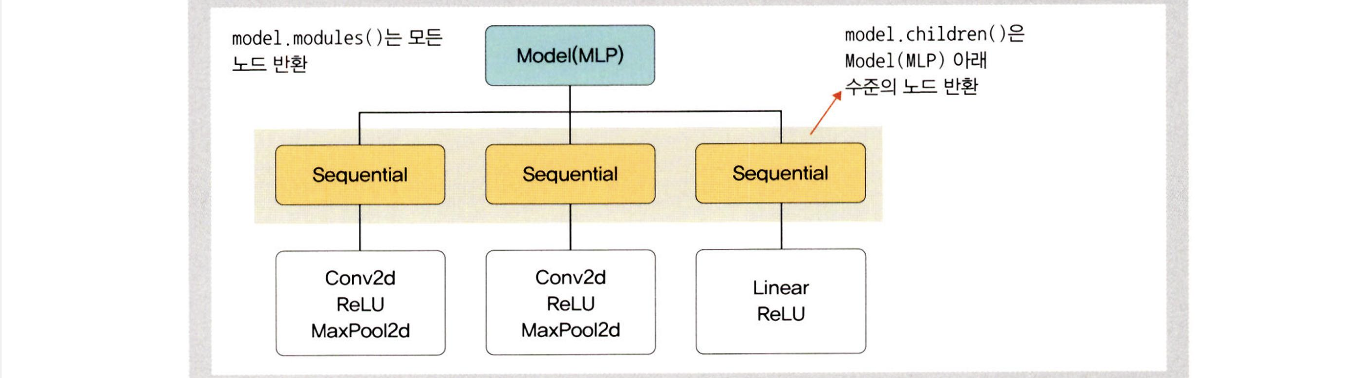

- model.modules() : 모델의 네트워크에 대한 모든 노드 반환
- model.children(): 같은 수준(level)의 하위 노드 반환

In [24]:
model = MLP()
print("Printing children\n----------------------")
print(list(model.children()))
print("\n\nPrinting Modules\n----------------------")
print(list(model.modules()))

Printing children
----------------------
[Sequential(
  (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
), Sequential(
  (0): Conv2d(64, 30, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
), Sequential(
  (0): Linear(in_features=750, out_features=10, bias=True)
  (1): ReLU(inplace=True)
)]


Printing Modules
----------------------
[MLP(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 30, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=75

### 2.4 함수로 신경망을 정의하는 방법

- Sequential을 이용하는 것과 동일하지만, 함수로 선언할 경우 변수에 저장해 놓은 계층들을 재사용할 수 있는 장점이 있음 but, 모델이 복잡해지는 단점도 있음
  - 복잡한 모델의 경우에는 함수를 이용하는 것보다는 nn.Module()을 상속받아 사용하는 것이 편리

In [ ]:
def MLP(in_features=1, hidden_features=20, out_features=1):
  hidden = nn.Linear(in_features=in_features, out_features=hidden_features, bias=True)
  activation = nn.ReLU()
  output = nn.Linear(in_features=hidden_features, out_features=out_features, bias=Ture)
  net = nn.Sequential(hidden, activation, output)
  return net

#3. 모델의 파라미터 정의

1. 손실 함수
  - 학습하는 동안 출력과 실제 값(정답) 사이의 오차를 측정
  - wx + b를 계산한 값과 실제 값이 y의 오차를 구해서 모델의 정확성 측정
2. 옵티마이저
  - 데이터와 손실 함수를 바탕으로 모델의 업데이트 방법 결정
3. 학습률 스케줄러(learning rate scheduler)
  - 미리 지정한 횟수의 애포크를 지날 때마다 학습률을 감소시켜줌
  - 학습 초기에는 빠른 학습을 진행하다가 전역 최소점(global minimum)근처에 다다르면 학습룰을 줄여서 최적점을 찾아갈 수 있도록 해줌
4. 지표
  - 훈련과 테스트 단계를
  
---
- 전역 최소점과 최적점
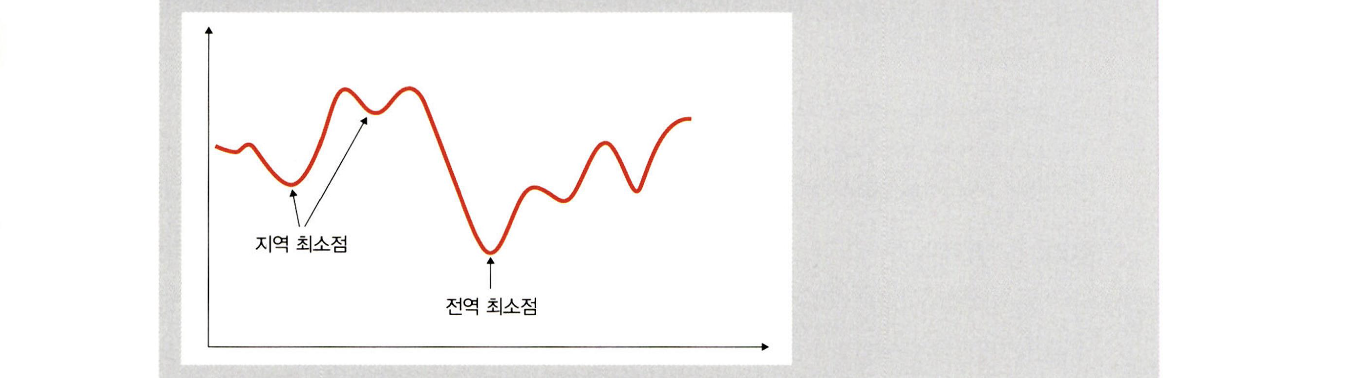
  - 전역 최소점(global minimum) : 오차가 가장 작을 때의 값 - 우리가 최종적으로 찾고자 하는 최적점
  - 지역 최소점(local minimum) : 전역 최소점을 찾아가는 과정에서 만나는 홀과 같은 것
    - 옵티마이저가 지역 최소점에서 학습을 멈추며 최솟값을 갖는 오차를 찾을 수 없는 문제 발생

In [ ]:
import torch
from torch.optim import optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,lr_lambda=lambda epoch: 0.95 ** epoch)

for epoch in range(1, 100+1): # 에포크 수만큼 뎅이터를 반복하여 처리
  for x,y in dataloader: # 배치 크기만큼 데이터를 가져와서 학습 진행
    optimizer.zero_grad()

loss_fn(model(x),y).backward()
optimizer.step()
scheduler.step()

# 4. 모델 훈련
- 만들어 둔 데이터로 모델을 학습시킴
- **학습시킴** : y = wx + b 라는 함수에서 적절한 w,b값을 찾는다는 의미
  - 임의의 값을 적용하여 시작 -> 전역 최소점에 이를 때까지 파라미터(w,b)계속 수정

- **optimizer.zero_grad()** : 기울기 초기화
  - 기울기 값에 대해 누적 계산이 필요하지 않을 때는 입력 값을 모델에 적용하기 전에 호출하여 미분값이 누적되지 않게 초기화 해 주어야함

- **loss.backward()** : 새로운 기울기 값이 이전 기울기 값에 누적하여 계산됨
  - RNN(순환신경망, Recurrent Neural Network) 모델 구현에 효율적

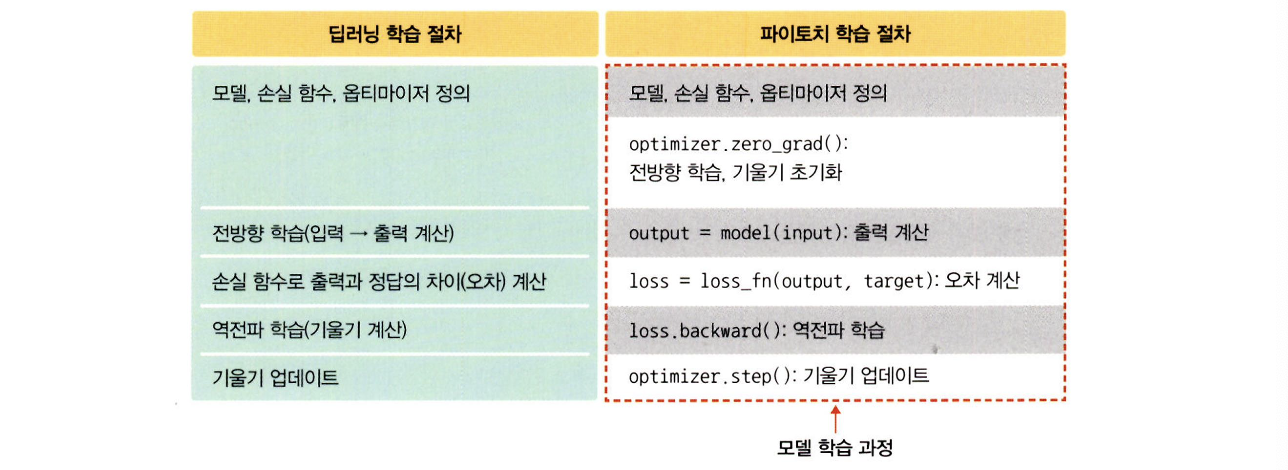

In [ ]:
for epoch in range(100):
  yhat = model(x_train)
  loss = criterion(yhat, y_train)
  optimizer.zero_grad() # 오차가 중첩적으로 쌓아지 않도록 초기화
  loss.backward()
  optimizer.step()

#5. 모델 평가
- 주어진 테스트 데이터셋을 사용하여 모델을 평가

In [26]:
pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 29.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

### 5.1 함수 이용 모델 평가

In [ ]:
import torch
import torchmetrics

preds = torch.randn(10,5).softmax(dim=1)
target = torch.randint(5,(10,))

acc = torchmetrics.funtional.accuracy(preds, target) # 모델을 평가하기 위해 torchmetrics.funtional.accuracy 이용

### 5.2 모듈 이용 모델 평가

In [ ]:
import torch
import torchmetrics
metric = torchmetrics.Accurary() # 모델 평가(정확도) 초기화

n_batches = 10
for i in range(n_batches):
  preds = torch.randn(10,5).softmax(dim=-1)
  target = toorch.randint(5,(10,))

  acc = metric(preds, target)
  print(f"Accurary on batch {i} : {acc}") # 현재 배치에서 모델 평가(정확도)

acc = metric.compute()
print(f"Accuracy on all data: {acc}") # 모든 배치에서 모델 평가(정확도)

#6. 훈련 과정 모니터링
- **텐서보드** : 학습에 사용되는 각종 파라미터 값이 어떻게 변화하는지 시각화하여 볼 수 있고, 성능을 추적하거나 평가하는 용도로 사용할 수 있음

1. 텐서보드를 설정(set up)
2. 텐서보드에 기록(write)
3. 텐서보드를 사용하여 모델 구조를 살펴봄